# Metrics time series

In [ ]:
!make -C .. agglomeration_extracts!make -C .. agglomeration_extracts

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pylandstats as pls
import swisslandstats as sls

from swiss_urbanization.data import settings as data_settings
from swiss_urbanization.visualization import settings as viz_settings

In [ ]:
urban_class = data_settings.EXTRACTS_URBAN
nonurban_class = data_settings.EXTRACTS_NONURBAN
nodata = data_settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

class_metrics = [
    'proportion_of_landscape', 'area_mn', 'largest_patch_index',
    'patch_density', 'edge_density', 'fractal_dimension_am',
    'landscape_shape_index', 'euclidean_nearest_neighbor_mn'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

# for the plot labels
metric_abbreviations = viz_settings.metric_abbreviations

In [ ]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res, nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

## Spatiotemporal analysis of the landscape metrics

In [ ]:
# auxiliary function to plot the time series of a metric for all agglomerations
# in one axis
def plot_metric_all_agglomerations(ax,
                                   metric,
                                   class_val=None,
                                   agglomeration_slugs=agglomeration_slugs,
                                   metric_abbreviations=metric_abbreviations):
    for agglomeration_slug in agglomeration_slugs:
        agglomeration_dict[agglomeration_slug].plot_metric(
            metric,
            class_val=class_val,
            ax=ax,
            plot_kws={'label': agglomeration_slug.capitalize()})
    ax.margins(y=.5)
    ax.legend()
    ax.set_ylabel(metric_abbreviations[metric])

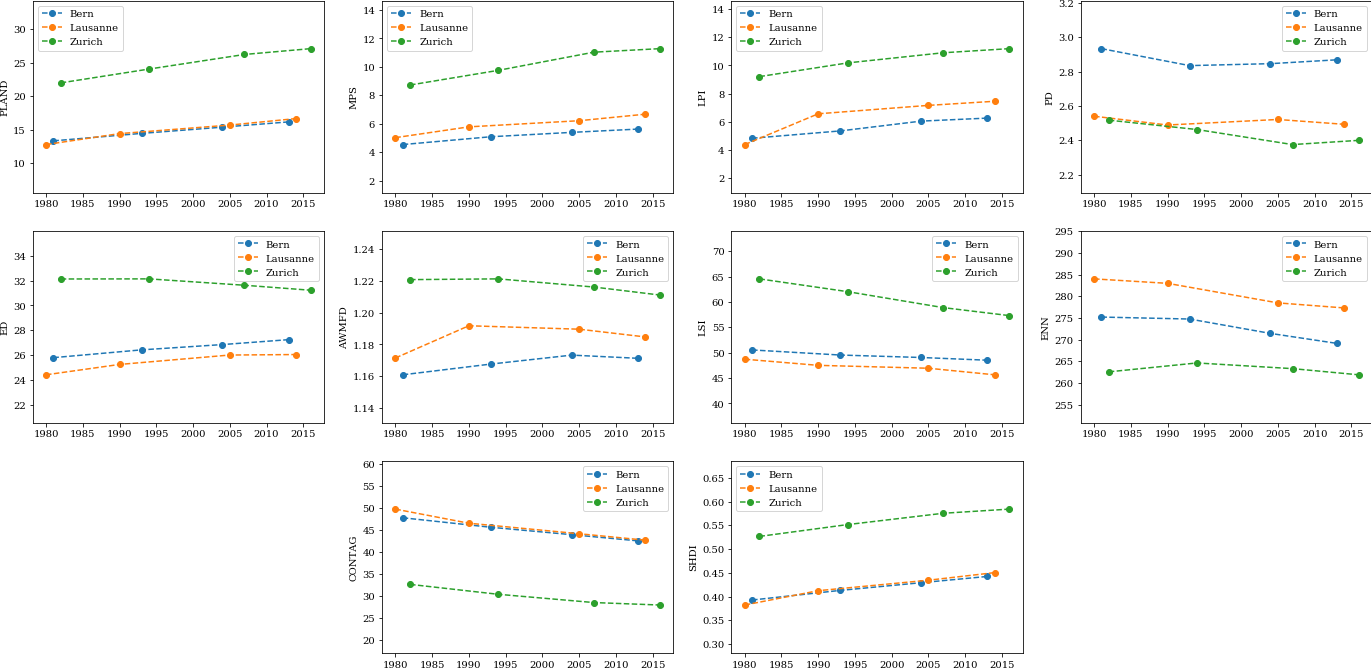

In [ ]:
num_cols = 4
num_metrics = len(class_metrics) + len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']    
fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(class_metrics, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    plot_metric_all_agglomerations(ax, metric, class_val=urban_class)

# the +2 accounts for: +1 to index starting at 1, +1 of margin to center lower
# column with only two metrics
for i, metric in enumerate(landscape_metrics, start=len(class_metrics)+2):
    ax = fig.add_subplot(num_rows, num_cols, i)
    plot_metric_all_agglomerations(ax, metric)

# fig.suptitle('Metrics for patches of urban classes', fontsize=20, y=.92)
fig.savefig('../reports/figures/metrics_time_series.pdf')

## Metric correlations

In [ ]:
metrics_df = pd.DataFrame(columns=class_metrics + landscape_metrics)
for agglomeration_slug in agglomeration_slugs:
    class_metrics_df = agglomeration_dict[agglomeration_slug].class_metrics_df
    landscape_metrics_df = agglomeration_dict[
        agglomeration_slug].landscape_metrics_df
    agglomeration_metrics_df = pd.concat([
        class_metrics_df.loc[urban_class][class_metrics],
        landscape_metrics_df[landscape_metrics]
    ], axis=1)
    # need minmax scaling for correlations to work
    agglomeration_metrics_df = agglomeration_metrics_df.apply(
        pd.to_numeric).apply(
            lambda x: (x.astype(float) - min(x)) / (max(x) - min(x)), axis=0)
    metrics_df = pd.concat([metrics_df, agglomeration_metrics_df],
                           ignore_index=True)

In [ ]:
metrics_df.corr()

metric                         proportion_of_landscape   area_mn  \
metric                                                             
proportion_of_landscape                       1.000000  0.994628   
area_mn                                       0.994628  1.000000   
largest_patch_index                           0.973453  0.967863   
patch_density                                -0.715461 -0.774352   
edge_density                                  0.309929  0.289020   
fractal_dimension_am                          0.182301  0.189477   
landscape_shape_index                        -0.987459 -0.991975   
euclidean_nearest_neighbor_mn                -0.730462 -0.691272   
contagion                                    -0.997935 -0.993336   
shannon_diversity_index                       0.999642  0.995257   

metric                         largest_patch_index  patch_density  \
metric                                                              
proportion_of_landscape                   0.9